In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtypes-

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada ResNet50 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
conv_base  = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip

Archive:  /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/ISICDatabase2.zip
  inflating: ISICDatabase2/Aleatoriodatabase.py  
   creating: ISICDatabase2/Test/
   creating: ISICDatabase2/Test/basal cell carcinoma/
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024331.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024332.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024345.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024360.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024403.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024411.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024431.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024432.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024436.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024443.jpg  
  inflating: ISICDatabase2/Test/basal cell carcinoma/ISIC_0024448.jpg 

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'ISICDatabase2/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'ISICDatabase2/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#validation_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(validation_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#test_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(test_dataset_n))

Found 1308 files belonging to 4 classes.
Found 325 files belonging to 4 classes.
Found 64 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 3 últimas capas

In [ ]:
#conv_base.trainable = False
conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x) #training= false
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(80,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(40,3,padding="same",activation="elu")(x)
x = tf.keras.layers.Conv2D(25,3,padding="same",activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(952, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                             

Fijar los hiperparámetros y entrenar la red

In [ ]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    batch_size=32,
    validation_data=validation_dataset,
    callbacks=callbacks_list)

Epoch 1/1000
41/41 [==============================] - ETA: 0s - loss: 29.3747 - accuracy: 0.5436
Epoch 1: val_accuracy improved from -inf to 0.51385, saving model to model20-12-2020_dp03031024.h5
41/41 [==============================] - 24s 190ms/step - loss: 29.3747 - accuracy: 0.5436 - val_loss: 24.5129 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 2/1000
41/41 [==============================] - ETA: 0s - loss: 16.9895 - accuracy: 0.6942
Epoch 2: val_accuracy improved from 0.51385 to 0.60923, saving model to model20-12-2020_dp03031024.h5
41/41 [==============================] - 6s 123ms/step - loss: 16.9895 - accuracy: 0.6942 - val_loss: 12.8084 - val_accuracy: 0.6092 - lr: 0.0010
Epoch 3/1000
41/41 [==============================] - ETA: 0s - loss: 8.9250 - accuracy: 0.7554
Epoch 3: val_accuracy improved from 0.60923 to 0.65538, saving model to model20-12-2020_dp03031024.h5
41/41 [==============================] - 6s 125ms/step - loss: 8.9250 - accuracy: 0.7554 - val_loss: 6.8063 - val_

Visualizando la pérdida y el accuracy durante el entrenamiento


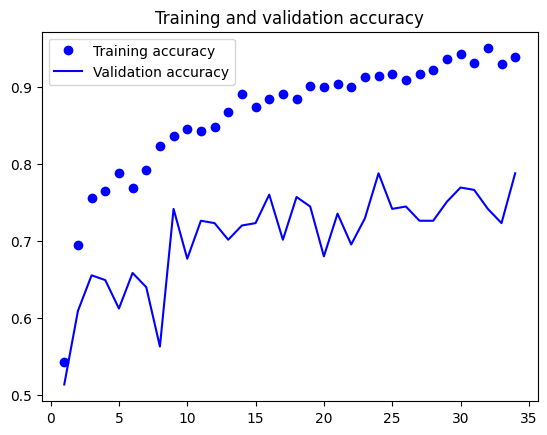

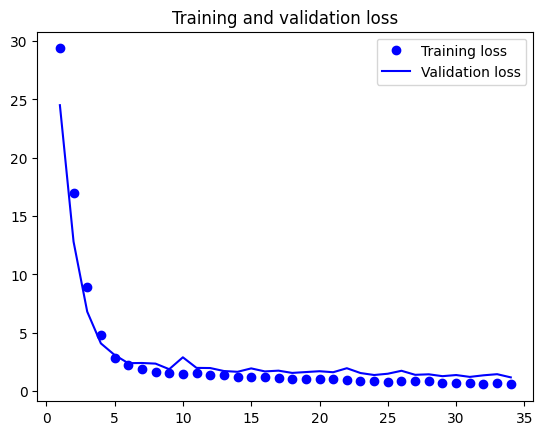

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
2/2 - 0s - loss: 2.0115 - accuracy: 0.6094 - 264ms/epoch - 132ms/step
Test Loss: 2.011475086212158
Test Accuracy: 0.609375


### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 980ms/step


Hago el siguiente procedimiento porque en el código anterior los últimos
vectores que se agregan en las listas no es del mismo tamaño que los que se venían agregando,
entonces extraigo eso últimos vectores para agregar sus elementos al final.

Además, para las siguientes matrices hago lo mismo

In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[283   0   5  13]
 [  0 336  10   5]
 [  1   4 262  19]
 [  2   3   2 363]]


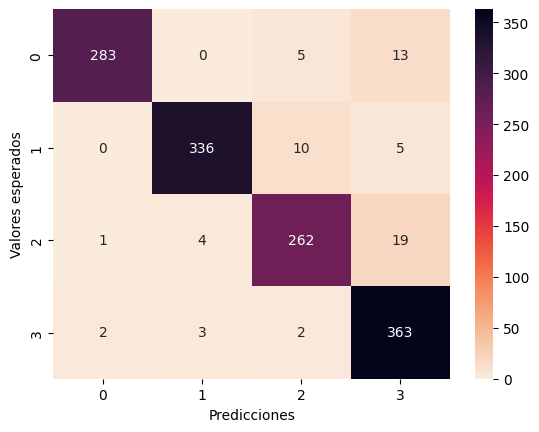

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       301
           1       0.98      0.96      0.97       351
           2       0.94      0.92      0.93       286
           3       0.91      0.98      0.94       370

    accuracy                           0.95      1308
   macro avg       0.95      0.95      0.95      1308
weighted avg       0.95      0.95      0.95      1308



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 23ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[61  1  4  9]
 [ 0 65 17  5]
 [ 3  9 48 11]
 [ 5  1  4 82]]


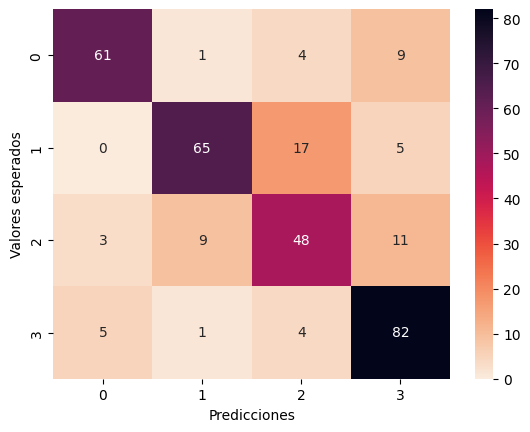

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        75
           1       0.86      0.75      0.80        87
           2       0.66      0.68      0.67        71
           3       0.77      0.89      0.82        92

    accuracy                           0.79       325
   macro avg       0.79      0.78      0.78       325
weighted avg       0.79      0.79      0.79       325



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[11  0  0  5]
 [ 1  3  6  6]
 [ 0  1 13  2]
 [ 1  0  3 12]]


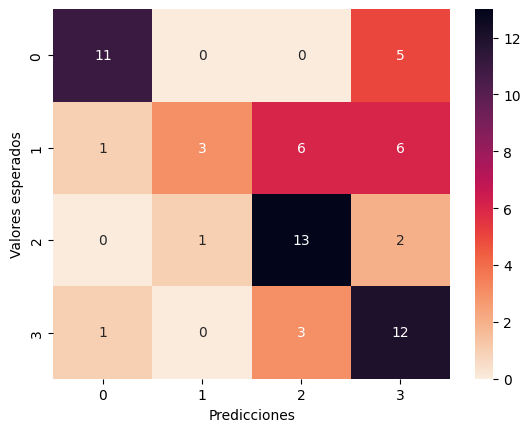

              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.75      0.19      0.30        16
           2       0.59      0.81      0.68        16
           3       0.48      0.75      0.59        16

    accuracy                           0.61        64
   macro avg       0.67      0.61      0.58        64
weighted avg       0.67      0.61      0.58        64



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_ResNet50.tflite"
tflite_model_file.write_bytes(tflite_model)

320480548

In [ ]:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

In [ ]:
# tflite_models_dir = pathlib.Path(".")
# tflite_fp16_model = converter.convert()
# tflite_model_fp16_file = tflite_models_dir/"model_VGG16_quant_f16.tflite"
# tflite_model_fp16_file.write_bytes(tflite_fp16_model)